In [2]:
import numpy as np
import sklearn as sk
import pylab as plt
import pandas as pd
import os
import torch
from tqdm.auto import tqdm
from nde.uci import get_uci_info, load_uci

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from common import gsave, gload

def train(x, y):
    clf = RandomForestClassifier(random_state=0, n_estimators=1, bootstrap=False) 
    clf.fit(x, y)
    return clf

def get_acc(name):
    d = load_uci(name) 
    X = d['X']
    y = d['y']
    n = d['n']
    I_tr = d['train_fold']
    I_te = d['test_fold']
    X_tr, y_tr = X[I_tr], y[I_tr]
    X_te, y_te = X[I_te], y[I_te]
    nc = d['num_classes']

    f = train(X_tr, y_tr)
    preds = f.predict(X_te)

    acc = (preds == y_te).mean()
    return acc

In [3]:
uci = get_uci_info()

In [4]:
uci[(uci['n'] >= 200) & (uci['num_classes'] >= 2)].sort_values('n')

,name,n,num_classes,num_features
41,heart-va,200,5,12
22,conn-bench-sonar-mines-rocks,208,2,60
90,seeds,210,3,7
35,glass,214,6,9
94,spect,265,2,22
...,...,...,...,...
19,chess-krvk,28056,18,6
3,adult,48842,2,14
101,statlog-shuttle,58000,7,9
24,connect-4,67557,2,42


In [94]:
print(uci.to_string())

                               name       n  num_classes  num_features
0                           abalone    4177            3             8
1                acute-inflammation     120            2             6
2                   acute-nephritis     120            2             6
3                             adult   48842            2            14
4                         annealing     898            5            31
5                        arrhythmia     452           13           262
6                     audiology-std     196           18            59
7                     balance-scale     625            3             4
8                          balloons      16            2             4
9                              bank    4521            2            16
10                            blood     748            2             4
11                    breast-cancer     286            2             9
12               breast-cancer-wisc     699            2             9
13    

In [6]:
get_acc('wine')

0.9545454545454546

In [8]:
def joint_density(Y, L, nY=None, nL=None):
    if nY is None or nL is None:
        nY=np.max(Y)+1
        nL=np.max(L)+1
        
    C = np.zeros((nY, nL))
    for yhat, ell in zip(Y, L):
        C[yhat, ell] += 1
    C /= np.sum(C)
    return C

def apply_noise(Y, confusion_matx):
    C = torch.Tensor(confusion_matx)  # C[i, j] = Pr[j --> i]
    Y_new = np.empty_like(Y)
    for i in range(len(Y)):
        y = Y[i]
        p = C[:, y]
        yNew = torch.distributions.categorical.Categorical(probs=p).sample()
        Y_new[i] = yNew
    return Y_new

def train_uci_conf(name, C):
    d = load_uci(name) 
    X = d['X']
    y = d['y']
    n = d['n']
    I_tr = d['train_fold']
    I_te = d['test_fold']
    X_tr, y_tr = X[I_tr], y[I_tr]
    X_te, y_te = X[I_te], y[I_te]
    nc = d['num_classes']
    
    y_tr_orig = np.copy(y_tr)
    y_tr = apply_noise(y_tr_orig, C)

    f = train(X_tr, y_tr)
    predsTe = f.predict(X_te)
    predsTr = f.predict(X_tr)
    
    cm_tr = joint_density(predsTr, y_tr_orig, nY=nc,nL=nc)
    cm_tr_ideal = joint_density(y_tr, y_tr_orig,nY=nc,nL=nc)
    cm_te = joint_density(predsTe, y_te,nY=nc,nL=nc)

    res = dict(cm_tr=cm_tr, cm_tr_ideal=cm_tr_ideal, cm_te=cm_te)
    return res

Text(0.5, 1.0, 'Joint Density (Test)')

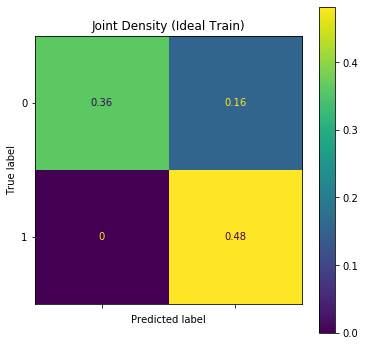

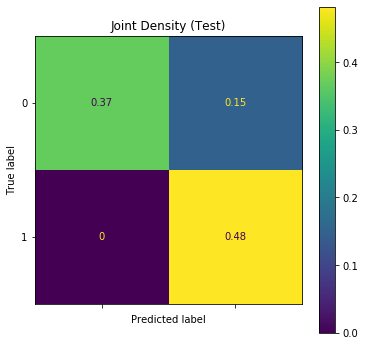

In [9]:
# C = np.eye(3) # C[i, j] = Pr[j --> i]
# C[2, 2] = 0.7
# C[1, 2] = 0.3
# C[0, 2] = 0.0
# res = train_uci_conf('molec-biol-splice', C)

# C = np.eye(3)
# C[1, 1] = 0.7
# C[2, 1] = 0.3
# res = train_uci_conf('wine', C)


C = np.eye(2) # C[i, j] = Pr[j --> i]
C[0,0] = 0.7
C[1,0] = 0.3
res = train_uci_conf('mushroom', C)

fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(res['cm_tr_ideal'].T, display_labels=map(str, range(C.shape[0])))
disp.plot(ax=ax)
ax.set_title('Joint Density (Ideal Train)')

fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(res['cm_te'].T, display_labels=map(str, range(C.shape[0])))
disp.plot(ax=ax)
ax.set_title('Joint Density (Test)')

In [98]:
def getC(p=0.3):
    # C[i, j] = Pr[j --> i]
    C = np.eye(3)
    C[2, 2] = (1-p)
    C[1, 2] = p
    C[0, 2] = 0.0
    return C

# ps = np.linspace(0, 1.0, 5)
ps = np.linspace(0, 1.0, 11)
uname = 'molec-biol-splice'
    
allres = []
for i, p in enumerate(ps):
    C = getC(p)
    res = train_uci_conf(uname, C)
    res['p'] = p
    allres.append(res)
    
gsave(allres, f'gs://ANONYMOUS/results/nde/uci/conf/{uname}_many')

In [14]:
# ps = np.linspace(0, 1.0, 5)
ps = np.linspace(0, 1.0, 11)
uname = 'wine'

def getC(p=0.3):
    # C[i, j] = Pr[j --> i]
    C = np.eye(3)
    C[1, 1] = (1-p)
    C[2, 1] = p
    return C

    
allres = []
for i, p in enumerate(ps):
    C = getC(p)
    res = train_uci_conf(uname, C)
    res['p'] = p
    allres.append(res)
    
gsave(allres, f'gs://ANONYMOUS/results/nde/uci/conf/{uname}_many')

In [100]:
# ps = np.linspace(0, 1.0, 5)
ps = np.linspace(0, 1.0, 11)
uname = 'mushroom'

def getC(p=0.3):
    # C[i, j] = Pr[j --> i]
    C = np.eye(2)
    C[0,0] = (1-p)
    C[1,0] = p
    return C

allres = []
for i, p in enumerate(ps):
    C = getC(p)
    res = train_uci_conf(uname, C)
    res['p'] = p
    allres.append(res)
    
gsave(allres, f'gs://ANONYMOUS/results/nde/uci/conf/{uname}_many')